In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib
import re
import spacy
import nltk

from io import StringIO
from html.parser import HTMLParser

from nltk import *
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/adminux/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/adminux/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#Initialize data fields for final dataset

dates=[]
titles=[]
locations=[]
people=[]
key_countries=[]
content_text=[]
links=[]
coord_list=[]
mentioned_countries=[]
keywords=[]
topic_categories=[]

#initializing clustering variables for later topic modeling

cluster_keywords=[]
cluster_number=[]

#Initialize the NLP object using the SPACY library
nlp = spacy.load("en_core_web_sm")

# Exploratory Data Analysis

In [3]:
source_file = './RegTransform_sample_dataset.csv'

In [4]:
df = pd.read_csv(filepath_or_buffer = source_file)

In [5]:
df.head()

,UID,CONTENT_TYPE,LOAD_DATE,LINK_URL,CONTENT,INSIGHT_NAME,ISSUING_BODY,JURISDICTION
0,9841051B-7A7F-4657-98A9-117A9B36C98B,html,2020-12-21 22:11:07.877,https://www.federalregister.gov/documents/2020...,<div> <span></span> </div> <div></div> <span><...,Public Inquiry,Postal Regulatory Commission,United States of America
1,C5FE84B7-E3B1-4677-8EDF-A60E7D358055,html,2020-12-21 20:36:15.410,https://www.federalregister.gov/documents/2020...,<div> <span></span> </div> <div></div> <span><...,Agency Information Collection Activities: Comm...,Export-Import Bank,United States of America
2,6DC38C33-FB75-4025-8D1E-C3F708E67E67,html,2021-02-10 01:27:06.263,https://www.federalregister.gov/documents/2021...,<div> <span></span> </div> <div></div> <span><...,Information Collection Activities; Comment Req...,Labor Statistics Bureau,United States of America
3,0EAAA615-87DB-4600-9A1F-507D6A7C1EBB,html,2020-12-27 17:56:17.440,https://www.federalregister.gov/documents/2020...,<div> <span></span> </div> <div></div> <span><...,Agency Information Collection Activities; Comm...,Workers Compensation Programs Office,United States of America
4,9155D9E6-4B38-443B-B43E-586431AC5251,html,2021-02-10 01:15:08.620,https://www.federalregister.gov/documents/2021...,<div> <span></span> </div> <div></div> <span><...,Black Lung Benefits Act Self-Insurance: Withdr...,Workers Compensation Programs Office,United States of America


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   UID           9999 non-null   object
 1   CONTENT_TYPE  9999 non-null   object
 2   LOAD_DATE     9999 non-null   object
 3   LINK_URL      9999 non-null   object
 4   CONTENT       9821 non-null   object
 5   INSIGHT_NAME  9827 non-null   object
 6   ISSUING_BODY  9999 non-null   object
 7   JURISDICTION  9999 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


## Feature selection

In [7]:
# Finidng null data

df.isnull().sum()

UID               0
CONTENT_TYPE      0
LOAD_DATE         0
LINK_URL          0
CONTENT         178
INSIGHT_NAME    172
ISSUING_BODY      0
JURISDICTION      0
dtype: int64

In [8]:
# drop null in Content

df.dropna(subset=['CONTENT'], inplace=True)
df.isnull().sum()

UID             0
CONTENT_TYPE    0
LOAD_DATE       0
LINK_URL        0
CONTENT         0
INSIGHT_NAME    0
ISSUING_BODY    0
JURISDICTION    0
dtype: int64

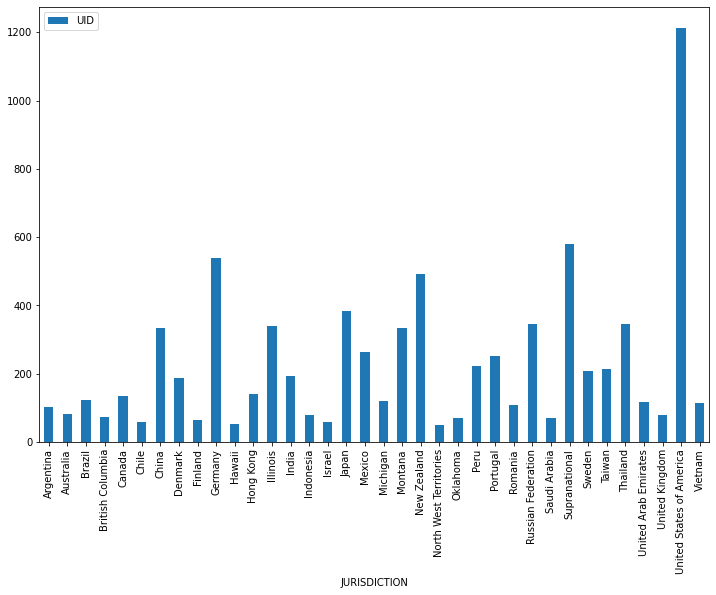

In [9]:
df_gb = df[['UID', 'JURISDICTION']]
df_gb = df_gb.groupby('JURISDICTION').count()
df_gb = df_gb[df_gb['UID']>50]

df_gb.plot(kind='bar', figsize=(12, 8));

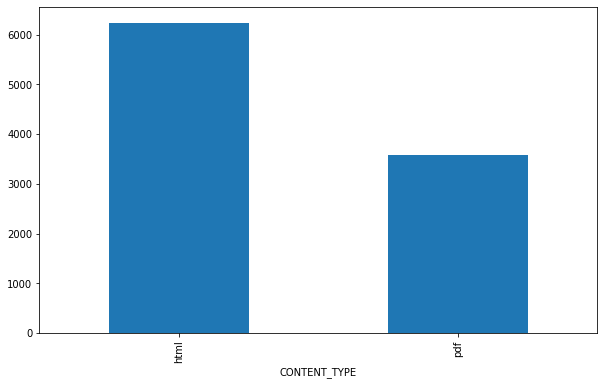

In [10]:
df_gb = df[['UID', 'CONTENT_TYPE']]
df_gb = df_gb.groupby('CONTENT_TYPE').size()
df_gb.plot(kind='bar', figsize=(10, 6));

## Finding duplicated in UIDs

Dublicated UIDs can affects fine-tuning as a noise in dataset


In [11]:

dublicated_id =[]
for id0, dubl_id in df.groupby('UID'):
    if len(dubl_id) > 1:
        dublicated_id.append(id0)

print('Number of dublicated UIDs: {}'.format(len(dublicated_id)))
        
pd.concat(dubl_id for _, dubl_id in df.groupby(['UID', 'CONTENT_TYPE']) if len(dubl_id) > 1)

Number of dublicated UIDs: 95


,UID,CONTENT_TYPE,LOAD_DATE,LINK_URL,CONTENT,INSIGHT_NAME,ISSUING_BODY,JURISDICTION
1726,03737C4E-D794-41D6-BD72-974DC1D9C12F,html,2021-02-15 21:35:48.913,https://www.boerse-frankfurt.de/nachrichten/f6...,"<meta http-equiv=""Content-Type"" content=""text...",DAX FLASH: Dax continues annual endrally,FSE Exchange,Germany
6975,03737C4E-D794-41D6-BD72-974DC1D9C12F,html,2021-02-15 21:35:48.913,https://www.boerse-frankfurt.de/nachrichten/f6...,"<meta http-equiv=""Content-Type"" content=""text...",DAX FLASH: Dax continues annual endrally,FSE Exchange,Germany
2449,059A3DFD-3DF0-4F45-83CE-408F0189F3C7,html,2021-04-08 11:14:21.247,https://www.cmfchile.cl/sitio/aplic/serdoc/ver...,"<meta http-equiv=""Content-Type"" content=""text...","<meta http-equiv=""Content-Type"" content=""text...",Comision para el Mercado Financiero (CMF),Chile
7191,059A3DFD-3DF0-4F45-83CE-408F0189F3C7,html,2021-04-08 11:14:21.247,https://www.cmfchile.cl/sitio/aplic/serdoc/ver...,"<meta http-equiv=""Content-Type"" content=""text...","<meta http-equiv=""Content-Type"" content=""text...",Comision para el Mercado Financiero (CMF),Chile
4841,07E577F3-2385-46E9-B861-81F660DD0E19,pdf,2021-04-25 19:28:24.247,https://www.jpx.co.jp/english/markets/statisti...,Long-Term Government Bond Futures Option Optio...,JGB Futures Option Options on 10-year JGB Futu...,Osaka Securities Exchange/JASDAQ,Japan
...,...,...,...,...,...,...,...,...
7199,F289F0DD-A621-416D-863A-5B18648DCAFC,pdf,2021-06-15 07:14:53.197,https://www.jpx.co.jp/english/markets/statisti...,"2021年 6月11日(金曜日) Friday, June 11, 2021 発行所(Nam...","2021年 6月11日(金曜日) Friday, June 11, 2021 発行所(Nam...",Osaka Securities Exchange/JASDAQ,Japan
4449,F360D6D0-2148-49A0-9B64-EA14297CE659,html,2021-02-06 00:53:09.440,https://www.boletinoficial.gob.ar/detalleAviso...,"<div> <div> <a href=""https://www.boletinoficia...",MILITARY PERSONNEL,Argentina Government,Argentina
8459,F360D6D0-2148-49A0-9B64-EA14297CE659,html,2021-02-06 00:53:09.440,https://www.boletinoficial.gob.ar/detalleAviso...,"<div> <div> <a href=""https://www.boletinoficia...",MILITARY PERSONNEL,Argentina Government,Argentina
3058,FA095AC5-A71D-4E3A-ABC2-33F840E5BAEE,pdf,2021-05-06 14:49:46.233,http://dbcf.ms.gov/wp-content/uploads/2020/06/...,Complaint # Mail or fax this completed complai...,Complaint # Mail or fax this completed complai...,Mississippi Department of Banking and Consumer...,Mississippi


### Removing dublicated UIDs

In [12]:
df = df.drop_duplicates(subset=['UID'], inplace= False)

## Defining function to parse HTML tags from text

In [13]:
class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [14]:
html = df.iloc[1,4]

In [15]:
txt = strip_tags(html)
print(txt)

     AGENCY: Export-Import Bank of the United States. SUMMARY: The Export-Import Bank of the United States (Ex-Im Bank), as part of its continuing effort to reduce paperwork and respondent burden, invites the general public and other Federal Agencies to comment on the proposed information collection, as required by the Paperwork Reduction Act of 1995. DATES: Comments must be received on or before January 19, 2021 to be assured of consideration. ADDRESSES: Comments may be submitted electronically on www.regulations.gov or by mail to Donna Schneider, Export-Import Bank of the United States, 811 Vermont Ave. NW, Washington, DC 20571. End Preamble Start Supplemental Information SUPPLEMENTARY INFORMATION: By neutralizing the effect of export credit support offered by foreign governments and by absorbing credit risks that the private sector will not accept, Ex-Im Bank enables U.S. exporters to compete fairly in foreign markets on the basis of price and product. Under the Working Capital Guar

## Save a small sample of data for further analysis

In [16]:
#Sampled dataset

sample_file = './sample.csv'
df_s = df.head(50)
df_s.to_csv(path_or_buf = sample_file)


df_s = pd.read_csv(filepath_or_buffer = sample_file)
df_s.head()


,Unnamed: 0,UID,CONTENT_TYPE,LOAD_DATE,LINK_URL,CONTENT,INSIGHT_NAME,ISSUING_BODY,JURISDICTION
0,0,9841051B-7A7F-4657-98A9-117A9B36C98B,html,2020-12-21 22:11:07.877,https://www.federalregister.gov/documents/2020...,<div> <span></span> </div> <div></div> <span><...,Public Inquiry,Postal Regulatory Commission,United States of America
1,1,C5FE84B7-E3B1-4677-8EDF-A60E7D358055,html,2020-12-21 20:36:15.410,https://www.federalregister.gov/documents/2020...,<div> <span></span> </div> <div></div> <span><...,Agency Information Collection Activities: Comm...,Export-Import Bank,United States of America
2,2,6DC38C33-FB75-4025-8D1E-C3F708E67E67,html,2021-02-10 01:27:06.263,https://www.federalregister.gov/documents/2021...,<div> <span></span> </div> <div></div> <span><...,Information Collection Activities; Comment Req...,Labor Statistics Bureau,United States of America
3,3,0EAAA615-87DB-4600-9A1F-507D6A7C1EBB,html,2020-12-27 17:56:17.440,https://www.federalregister.gov/documents/2020...,<div> <span></span> </div> <div></div> <span><...,Agency Information Collection Activities; Comm...,Workers Compensation Programs Office,United States of America
4,4,9155D9E6-4B38-443B-B43E-586431AC5251,html,2021-02-10 01:15:08.620,https://www.federalregister.gov/documents/2021...,<div> <span></span> </div> <div></div> <span><...,Black Lung Benefits Act Self-Insurance: Withdr...,Workers Compensation Programs Office,United States of America


## Convert sampled HTML contents to text and save as csv file

In [17]:
# Convert html content to text
df_s['CONTENT'] = df_s['CONTENT'].apply(lambda x: strip_tags(x))

df_s.to_csv(path_or_buf = './sample_txt.csv')

# list_txt = df_s['CONTENT']
# for i in range(31):
#     text_file = open(str(i)+'_content.txt', 'wt')
#     text_file.write(list_txt[i])
#     text_file.close()

In [18]:
df_s.head(10)

,Unnamed: 0,UID,CONTENT_TYPE,LOAD_DATE,LINK_URL,CONTENT,INSIGHT_NAME,ISSUING_BODY,JURISDICTION
0,0,9841051B-7A7F-4657-98A9-117A9B36C98B,html,2020-12-21 22:11:07.877,https://www.federalregister.gov/documents/2020...,AGENCY: Postal Regulatory Commission. ACT...,Public Inquiry,Postal Regulatory Commission,United States of America
1,1,C5FE84B7-E3B1-4677-8EDF-A60E7D358055,html,2020-12-21 20:36:15.410,https://www.federalregister.gov/documents/2020...,AGENCY: Export-Import Bank of the United ...,Agency Information Collection Activities: Comm...,Export-Import Bank,United States of America
2,2,6DC38C33-FB75-4025-8D1E-C3F708E67E67,html,2021-02-10 01:27:06.263,https://www.federalregister.gov/documents/2021...,"AGENCY: Bureau of Labor Statistics, Depar...",Information Collection Activities; Comment Req...,Labor Statistics Bureau,United States of America
3,3,0EAAA615-87DB-4600-9A1F-507D6A7C1EBB,html,2020-12-27 17:56:17.440,https://www.federalregister.gov/documents/2020...,ACTION: Notice. SUMMARY: The Department o...,Agency Information Collection Activities; Comm...,Workers Compensation Programs Office,United States of America
4,4,9155D9E6-4B38-443B-B43E-586431AC5251,html,2021-02-10 01:15:08.620,https://www.federalregister.gov/documents/2021...,AGENCY: Office of Workers' Compensation P...,Black Lung Benefits Act Self-Insurance: Withdr...,Workers Compensation Programs Office,United States of America
5,5,76DBF3CB-63AC-49D9-9119-509F00E10577,html,2020-12-21 22:17:54.547,https://www.federalregister.gov/documents/2020...,Notice is hereby given pursuant to the An...,"United States v. Intuit Inc., et al.; Proposed...",Antitrust Division,United States of America
6,6,3104063D-83E8-4794-8531-5AD0A77C1C6A,html,2020-12-31 17:43:31.373,https://www.federalregister.gov/documents/2020...,Notice is hereby given pursuant to the An...,"United States, et al. v. Harvard Pilgrim Healt...",Antitrust Division,United States of America
7,7,04C47556-79AD-4AC7-B766-BAB5A76F1DB9,html,2021-01-02 16:56:47.147,https://www.federalregister.gov/documents/2020...,Notice is hereby given pursuant to the An...,"United States, et al. v. Harvard Pilgrim Healt...",Antitrust Division,United States of America
8,8,2879E818-6B43-4150-8DCC-CA283DB531AE,html,2021-04-21 16:53:55.780,https://www.federalregister.gov/documents/2021...,Notice Pursuant to the National Cooperative Re...,Notice Pursuant to the National Cooperative Re...,Antitrust Division,United States of America
9,9,98C12DFB-224F-4F0E-9F63-A7F9397FBAD6,html,2020-12-31 17:16:27.450,https://www.govinfo.gov/content/pkg/FR-2020-12...,"86996 Federal Register / Vol. 85, No. 251 / Th...",DEPARTMENT OF THE TREASURY United States Mint ...,United States Mint,United States of America


# Named Entity Recognition (NER)

In [19]:
nlp = spacy.load("en_core_web_sm")

Applying NER technique to one sample content (row # 2) to study its performance

In [20]:
doc = nlp(txt)

In [21]:
spacy.displacy.serve(doc, style='ent')

/home/adminux/anaconda3/envs/nlp1/lib/python3.8/runpy.py:194: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  return _run_code(code, main_globals, None,



Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


### Extacting tagged entities from SpaCy NER

In [22]:
for ent in doc.ents:
    print("{} -> {}".format(ent.text,ent.label_))

Export-Import Bank of the United States -> ORG
The Export-Import Bank of the United States -> ORG
Ex-Im Bank -> ORG
Federal Agencies -> ORG
the Paperwork Reduction Act -> LAW
1995 -> DATE
January 19, 2021 -> DATE
Donna Schneider -> PERSON
Export-Import Bank of the United States -> ORG
811 -> CARDINAL
Vermont Ave -> FAC
Washington -> GPE
20571 -> CARDINAL
Ex-Im Bank -> ORG
U.S. -> GPE
the Working Capital Guarantee Program -> ORG
Ex-Im Bank -> ORG
Ex-Im Bank -> ORG
12 -> CARDINAL
The Notice of Claim and Proof of Loss -> ORG
Working Capital Guarantee -> ORG
Export-Import Bank -> ORG
Working Capital Guarantee -> ORG
3048 -> CARDINAL
Need -> PERSON
12 -> CARDINAL
U.S. -> GPE
17 -> CARDINAL
Estimated Time per Respondent -> ORG
1 hour -> TIME
Annual -> DATE
17 hours -> TIME
Frequency -> PERSON
17 hours -> TIME
42.50 -> MONEY
722.50 -> MONEY
Overhead -> ORG
20% -> PERCENT
867 -> MONEY
Bassam Doughman -> PERSON
Office of the Chief Information -> ORG
2020-27774 -> DATE
12-16-20 -> DATE
8:45 am -

In [23]:
doc=nlp(txt)
lstdate=[X.text for X in doc.ents if X.label_ == 'DATE']
date_dict=dict.fromkeys(lstdate,0)
date_dict=list(date_dict)
print(date_dict)

['1995', 'January 19, 2021', 'Annual', '2020-27774', '12-16-20']


# k-mean clustring for estimating issuance type 

In [24]:
#The first function pre-processes text by lowering the case of characters and removing special characters. 

def pre_process(text):
    text=text.lower()
    text=re.sub("</?.*?>"," <> ",text)
    text=re.sub("(\\d|\\W)+"," ",text)
    return text

#This function maps matrices to coordinates. The TF-IDF function maps 
#Frequency scores to matrices, which then need to be sorted to help us find our keywords. 

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

#As with above, this is a helper function that will assist in the sorting and
#selection of keywords once the frequencies have been mapped to matrices. 
#This function specifically helps us to choose the most relevant keywords, 
#based on TF-IDF statistics

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    return results

#The final function, which incorporates the above helper functions, 
#Applies a TF-IDF algorithm to the body of our text to find keywords based
#on frequency of usage. 

def get_keywords(content_list):
    iteration=1
    processed_text=[pre_process(text) for text in content_list]
    stop_words=set(stopwords.words('english'))
    cv=CountVectorizer(max_df=0.85,stop_words=stop_words)
    word_count_vector=cv.fit_transform(processed_text)

    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(word_count_vector)

    feature_names=cv.get_feature_names()

    for i in range(len(processed_text)):
        #print('Getting Keywords',iteration,'/',len(content_list))
        doc=processed_text[i]
        tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))
        sorted_items=sort_coo(tf_idf_vector.tocoo())
        keys=extract_topn_from_vector(feature_names,sorted_items,10)
        keywords.append(list(keys.keys()))
        iteration+=1

In [25]:
keyword_lst = get_keywords(df_s['CONTENT'])

### Finding keywords based on frequency of usage (TF-IDF statistics)

In [26]:

print(keywords)

[['postal', 'uso', 'commission', 'service', 'delivery', 'offices', 'report', 'density', 'maximizing', 'fy'], ['guarantee', 'export', 'bank', 'claim', 'im', 'working', 'capital', 'import', 'ex', 'credit'], ['laus', 'bls', 'collection', 'estimates', 'program', 'unemployment', 'labor', 'employment', 'statistics', 'manual'], ['dol', 'suggs', 'anjanette', 'collection', 'icr', 'burden', 'estimated', 'comments', 'undertaking', 'owcp'], ['owcp', 'self', 'workers', 'compensation', 'jan', 'insurance', 'lung', 'guidance', 'bulletin', 'black'], ['karma', 'tax', 'defendants', 'divestiture', 'credit', 'judgment', 'ddiy', 'intuit', 'preparation', 'trustee'], ['defendants', 'divestiture', 'hampshire', 'acquirer', 'judgment', 'tufts', 'groups', 'health', 'freedom', 'crc'], ['defendants', 'divestiture', 'hampshire', 'acquirer', 'judgment', 'tufts', 'groups', 'health', 'freedom', 'crc'], ['odva', 'co', 'ltd', 'membership', 'antitrust', 'tokyo', 'japan', 'korea', 'document', 'inc'], ['mint', 'coin', 'unit

In [27]:

cluster_keywords=[]
cluster_number=[]


#Getting keywords from content lists to help with categorising topic clusters later

def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    for i,r in df.iterrows():
        cluster_keywords.append(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
        
#Applying clustering to content lists for topic modeling

def get_topics(content_list):
    processed_text=[pre_process(text) for text in content_list]
    stop_words=set(stopwords.words('english'))
    cv=CountVectorizer(max_df=0.85,stop_words=stop_words)
    word_count_vector=cv.fit_transform(processed_text)

    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(word_count_vector)

    feature_names=cv.get_feature_names()
    vector=tfidf_transformer.transform(cv.transform(processed_text))


    clusters = MiniBatchKMeans(n_clusters=20, init_size=1024, batch_size=2048, random_state=101).fit_predict(vector)
    for cluster in clusters:
        cluster_number.append(int(cluster))
  
    get_top_keywords(vector, clusters, cv.get_feature_names(), 20)

In [28]:
get_topics(df_s['CONTENT'])

In [29]:
print(cluster_keywords)
print(cluster_number)

['liaison,reports,june,broadening,va,jsp,liaisons,od,alexandria,eisenhower,committee,presentation,virtual,remarks,meeting,foundation,oia,science,nsf,ceose', 'harvard,insurance,states,court,assets,crc,united,trustee,freedom,tax,health,final,karma,groups,tufts,hampshire,acquirer,judgment,divestiture,defendants', 'burden,government,omb,sba,fraud,comments,account,estimated,reserve,agency,sbas,disbursement,use,rural,accounts,housing,collection,mfh,funds,supervised', 'commission,start,program,self,agencies,workers,proposed,bank,labor,burden,fcc,owcp,laus,rule,comments,exchange,ltse,bitcoin,capital,collection', 'pre,combat,amr,attending,carb,http,presidential,june,health,bacteria,antibiotics,resistant,advisory,combating,council,hhs,resistance,meeting,antibiotic,paccarb', 'environmental,final,requirements,steubenville,mercury,virginia,state,section,naaqs,west,action,nonattainment,ozone,sip,emissions,air,certification,rule,area,epa', 'basements,suspension,december,management,county,butler,colle

### Cross-references keywords with cluster word banks to assign a topic category to each group

In [30]:

act=['act','bill','congress','peshmerga','enacted']

amendment=['amendment','amend','previous']

bill=['bill', 'legislation','legislature','proposed','consideration', 'congress']

fine=['fine','financial','penalty','paid','pay','punishment', 'offence','crime', 'court', 'judge']

law=['law','rule','goverment','order', 'pass', 'authorize']

policy=['policy','principles','guide','authority']

suspension=['suspension','inform','entity','suspended','activity']

warning=['warning','compliance','non-compliance','statement']

notice=['notice', 'filing']

order=['order', 'command', 'instruction', 'force']

research=['research', 'report', 'finding', 'project', 'observation' ]

complaint=['complaint', 'claim', 'plaintiff', 'remedy', 'facts', 'legal', 'reason']

annex=['annex', 'attachment', 'accompanying']

cat_list=[act, amendment, bill, fine, law, policy, suspension, warning, notice, order, research, complaint, annex]

topic_dict={}

for i in range(len(cluster_keywords)):
    temp_list=[]
    for n in nltk.word_tokenize(cluster_keywords[i]):
        for item in cat_list:
              if n in item:
                    temp_list.append(item[0])
  
    temp_dict=dict.fromkeys(temp_list,0)
    temp_list=list(temp_dict)

    topic_dict[i] = temp_list

print(topic_dict)
for num in cluster_number:
    topic_categories.append(topic_dict[num])

{0: [], 1: ['fine'], 2: [], 3: ['bill', 'law'], 4: [], 5: ['law'], 6: ['suspension'], 7: ['law', 'order'], 8: ['law'], 9: ['bill', 'law'], 10: ['amendment'], 11: ['policy'], 12: [], 13: [], 14: ['research'], 15: [], 16: [], 17: [], 18: [], 19: []}


# Transforming provided dataset for QA process

In [31]:
#Sampled dataset

sample_file = './sample.csv'

df_s = pd.read_csv(filepath_or_buffer = sample_file)
df_s.head()


,Unnamed: 0,UID,CONTENT_TYPE,LOAD_DATE,LINK_URL,CONTENT,INSIGHT_NAME,ISSUING_BODY,JURISDICTION
0,0,9841051B-7A7F-4657-98A9-117A9B36C98B,html,2020-12-21 22:11:07.877,https://www.federalregister.gov/documents/2020...,<div> <span></span> </div> <div></div> <span><...,Public Inquiry,Postal Regulatory Commission,United States of America
1,1,C5FE84B7-E3B1-4677-8EDF-A60E7D358055,html,2020-12-21 20:36:15.410,https://www.federalregister.gov/documents/2020...,<div> <span></span> </div> <div></div> <span><...,Agency Information Collection Activities: Comm...,Export-Import Bank,United States of America
2,2,6DC38C33-FB75-4025-8D1E-C3F708E67E67,html,2021-02-10 01:27:06.263,https://www.federalregister.gov/documents/2021...,<div> <span></span> </div> <div></div> <span><...,Information Collection Activities; Comment Req...,Labor Statistics Bureau,United States of America
3,3,0EAAA615-87DB-4600-9A1F-507D6A7C1EBB,html,2020-12-27 17:56:17.440,https://www.federalregister.gov/documents/2020...,<div> <span></span> </div> <div></div> <span><...,Agency Information Collection Activities; Comm...,Workers Compensation Programs Office,United States of America
4,4,9155D9E6-4B38-443B-B43E-586431AC5251,html,2021-02-10 01:15:08.620,https://www.federalregister.gov/documents/2021...,<div> <span></span> </div> <div></div> <span><...,Black Lung Benefits Act Self-Insurance: Withdr...,Workers Compensation Programs Office,United States of America


In [32]:
# Convert html content to text
df_s['CONTENT'] = df_s['CONTENT'].apply(lambda x: strip_tags(x))

df_s.to_csv(path_or_buf = './sample_txt.csv')

In [33]:
nq_as_squad = {"version": '0.1', "data": []}

for index, row in df_s.iterrows():
    
    input_data = {"title": '',
          "paragraphs":
              [{"context": row['CONTENT'],
                "qas": [{"id": row['UID']+'_1',
                         "question": 'When is publication issue filled date?'},
                        {"id": row['UID']+'_2',
                         "question": 'When is compliance date?'},
                        {"id": row['UID']+'_3',
                         "question": 'When is effective applicable date?'},
                        {"id": row['UID']+'_4',
                         "question": 'When is Repeal date?'},
                        {"id": row['UID']+'_5',
                         "question": 'What is consultation period?'},
                        {"id": row['UID']+'_6',
                         "question": 'What is issuing department body?'}
                       
                       ]}]}
    nq_as_squad["data"].append(input_data)

In [34]:
with open('sample_data.json', 'w', encoding='utf-8') as f:
    json.dump(nq_as_squad, f, ensure_ascii=False) #, indent=4


#### Continued ...